In [3]:
import numpy as np
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
sns.set_palette("colorblind")
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.weight'] = 'light'
rcParams['mathtext.fontset'] = 'cm'
rcParams['mathtext.rm'] = 'serif'
mpl.rcParams["figure.dpi"] = 500
import cartopy.crs as ccrs
import cartopy as ct
import matplotlib.colors as c
import regionmask
import cmasher as cmr
import scipy
from cartopy.util import add_cyclic_point
mpl.rcParams['hatch.linewidth'] = 0.375
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from geocat.comp import eofunc_eofs, eofunc_pcs
from datetime import datetime
import warnings
from matplotlib.patches import Rectangle
import random
import numba
import statsmodels.api as sm
from sklearn.metrics import r2_score
import pandas as pd
import os
import sys
import glob

# Step 1: Add parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), "/scratch/ivyglade/pdo/"))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Step 2: Now you can import file.py
import pdo_functions  # assuming file.py contains functions/classes

import importlib
importlib.reload(pdo_functions)

<module 'pdo_functions' from '/scratch/ivyglade/pdo/pdo_functions.py'>

In [4]:
files = sorted(glob.glob('/hurrell-scratch2/ivyglade/pdo/storm_reports/StormEvents_details-ftp_v1.0_d*.csv'))

In [5]:
# Import a single ERA5 file so that we have a lat/lon grid for reference
era5_data = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ERA5_cape/ERA5_cape/1940s/daily_max/e5.oper.an.sfc.128_059_cape.daily_max.19400101-19491231.nc')

In [6]:
# Subset a CONUS box
era5_data_conus = era5_data['CAPE'].sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))

In [8]:
# Open SST data and compute the PDO and Nino3.4
sst = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/HadISST_sst.nc')['sst']

pdo = pdo_functions.pdo_from_hadisst(sst, 1980, 2010)

oni = pdo_functions.oni_moving_base(sst)

In [26]:
# 3- month rolling mean
oni_rolling = oni.rolling(time=3, center=True).mean()
oni_rolling_1980_2024 = oni_rolling.sel(time=oni_rolling.time.dt.year.isin(np.arange(1980, 2025, 1)))
oni_rolling_1980_2024_mam = oni_rolling_1980_2024.sel(time=oni_rolling_1980_2024.time.dt.month.isin([3, 4, 5])).resample(time='YE').mean()

# Calculating when El Nino and La Nina events occur
oni_calc = np.zeros((1668))
for i in range(1668):
    if i < 5:
        continue
    else:
        if (oni_rolling[(i-4)] > 0.5) & (oni_rolling[(i-3)] > 0.5) & (oni_rolling[(i-2)] > 0.5) & (oni_rolling[(i-1)] > 0.5) & (oni_rolling[i] > 0.5):
            oni_calc[i] = 1
        elif (oni_rolling[(i-4)] < -0.5) & (oni_rolling[(i-3)] < -0.5) & (oni_rolling[(i-2)] < -0.5) & (oni_rolling[(i-1)] < -0.5) & (oni_rolling[i] < -0.5):
            oni_calc[i] = -1
        else:
            continue

# Coonvert to XR
oni_calc_xr = xr.DataArray(oni_calc, coords={'time':oni['time']}, dims=['time'])

# 1940-2024 only
oni_1980_2024 = oni_calc_xr.sel(time=oni_calc_xr.time.dt.year.isin(np.arange(1980, 2025, 1)))
oni_1980_2024_mam = oni_1980_2024.sel(time=oni_1980_2024.time.dt.month.isin([3, 4, 5]))

# Need to calculate when El Nino/La Nina Occurs in a given year
oni_1980_2024_mam_ann = np.zeros((45))
for i in range(45):
    if oni_1980_2024_mam[i*3: (i+1)*3].sum(axis=0) > 0:
        oni_1980_2024_mam_ann[i] = 1

    elif oni_1980_2024_mam[i*3: (i+1)*3].sum(axis=0) < 0:
        oni_1980_2024_mam_ann[i] = -1

    else:
        continue

In [27]:
# Convert pdo to xarray
pdo_xr = xr.DataArray(pdo, coords={'time':sst['time']}, dims=['time'])

# Subset only 1940-2024
pdo_1980_2024 = pdo_xr.sel(time=pdo_xr.time.dt.year.isin(np.arange(1980, 2025, 1)))

# only MAM and take seasonal averages
pdo_1980_2024_mam = pdo_1980_2024.sel(time=pdo_1980_2024.time.dt.month.isin([3, 4, 5])).resample(time='YE').mean()

# aligning time arrays with that of CAPE
oni_rolling_1980_2024_mam['time'] = pdo_1980_2024_mam['time']

oni_ann_xr = xr.DataArray(oni_1980_2024_mam_ann, coords={'time':pdo_1980_2024_mam['time']}, dims=['time'])

In [12]:
# Read and concatenate in order
storm_reports = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)

/tmp/ipykernel_62978/3445745825.py:2: DtypeWarning: Columns (26,48) have mixed types. Specify dtype option on import or set low_memory=False.
  storm_reports = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)
/tmp/ipykernel_62978/3445745825.py:2: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  storm_reports = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)
/tmp/ipykernel_62978/3445745825.py:2: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  storm_reports = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)
/tmp/ipykernel_62978/3445745825.py:2: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  storm_reports = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)
/tmp/ipykernel_62978/3445745825.py:2: DtypeWarning: Columns (29,34,35,37) have mixed types. Sp

In [13]:
storm_reports['BEGIN_YEARMONTH'] = pd.to_datetime(storm_reports['BEGIN_YEARMONTH'], format='%Y%m')
storm_reports['END_YEARMONTH'] = pd.to_datetime(storm_reports['END_YEARMONTH'], format='%Y%m')

In [14]:
# Extract the month
storm_reports["MONTH"] = storm_reports["BEGIN_YEARMONTH"].dt.month

In [15]:
# Specify different storm types
tornados = storm_reports[storm_reports['EVENT_TYPE'].isin(['Tornado'])]
hail = storm_reports[storm_reports['EVENT_TYPE'].isin(['Hail'])]
tstorm_wind = storm_reports[storm_reports['EVENT_TYPE'].isin(['Thunderstorm Wind'])]

In [16]:
# Subset storm reports by time periods
tornados_mam = tornados[tornados['BEGIN_YEARMONTH'].dt.month.isin([3, 4, 5])]
tornados_mar = tornados[tornados['BEGIN_YEARMONTH'].dt.month.isin([3])]
tornados_apr = tornados[tornados['BEGIN_YEARMONTH'].dt.month.isin([4])]
tornados_may = tornados[tornados['BEGIN_YEARMONTH'].dt.month.isin([5])]

hail_mam = hail[hail['BEGIN_YEARMONTH'].dt.month.isin([3, 4, 5])]
hail_mar = hail[hail['BEGIN_YEARMONTH'].dt.month.isin([3])]
hail_apr = hail[hail['BEGIN_YEARMONTH'].dt.month.isin([4])]
hail_may = hail[hail['BEGIN_YEARMONTH'].dt.month.isin([5])]

tstorm_wind_mam = tstorm_wind[tstorm_wind['BEGIN_YEARMONTH'].dt.month.isin([3, 4, 5])]
tstorm_wind_mar = tstorm_wind[tstorm_wind['BEGIN_YEARMONTH'].dt.month.isin([3])]
tstorm_wind_apr = tstorm_wind[tstorm_wind['BEGIN_YEARMONTH'].dt.month.isin([4])]
tstorm_wind_may = tstorm_wind[tstorm_wind['BEGIN_YEARMONTH'].dt.month.isin([5])]

In [17]:
# Want to mess around with grid size a little bit to see if we can get a more coherent signal
lat_edges = np.append(era5_data_conus['latitude'].values-0.25, 23.5)
lon_edges = np.append(era5_data_conus['longitude'].values-0.25, 294)

lat_edges_0_5deg = lat_edges[::2]
lon_edges_0_5deg = lon_edges[::2]

In [19]:
tornado_counts_mam = np.zeros((45, 50, 118))
for i in range(45):
    tornado_yr_mam = tornados_mam.loc[tornados_mam['BEGIN_YEARMONTH'].dt.year == 1980 + i]

    tornado_counts_mam[i] = pdo_functions.count_in_grid(tornado_yr_mam['BEGIN_LAT'], pdo_functions.convert_longitudes(tornado_yr_mam['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)

In [23]:
tstorm_wind_counts_mam = np.zeros((45, 50, 118))
for i in range(45):
    tstorm_wind_yr_mam = tstorm_wind_mam.loc[tstorm_wind_mam['BEGIN_YEARMONTH'].dt.year == 1980 + i]

    tstorm_wind_counts_mam[i] = pdo_functions.count_in_grid(tstorm_wind_yr_mam['BEGIN_LAT'], pdo_functions.convert_longitudes(tstorm_wind_yr_mam['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)

In [24]:
hail_counts_mam = np.zeros((45, 50, 118))
for i in range(45):
    hail_yr_mam = hail_mam.loc[hail_mam['BEGIN_YEARMONTH'].dt.year == 1980 + i]

    hail_counts_mam[i] = pdo_functions.count_in_grid(hail_yr_mam['BEGIN_LAT'], pdo_functions.convert_longitudes(hail_yr_mam['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)

In [32]:
lat_centers = 0.5 * (lat_edges_0_5deg[:-1] + lat_edges_0_5deg[1:])
lon_centers = 0.5 * (lon_edges_0_5deg[:-1] + lon_edges_0_5deg[1:])

In [34]:
# Convert to XR
tornado_counts_mam_xr = xr.DataArray(tornado_counts_mam, coords={'time':pdo_1980_2024_mam['time'], 'latitude':lat_centers, 'longitude':lon_centers}, dims=['time', 'latitude', 'longitude'])
tstorm_wind_counts_mam_xr = xr.DataArray(tstorm_wind_counts_mam, coords={'time':pdo_1980_2024_mam['time'], 'latitude':lat_centers, 'longitude':lon_centers}, dims=['time', 'latitude', 'longitude'])
hail_counts_mam_xr = xr.DataArray(hail_counts_mam, coords={'time':pdo_1980_2024_mam['time'], 'latitude':lat_centers, 'longitude':lon_centers}, dims=['time', 'latitude', 'longitude'])

In [119]:
# Compositing
tornado_pos_pdo = xr.where(pdo_1980_2024_mam > 0, tornado_counts_mam_xr, np.nan).dropna(dim='time').mean(dim='time')
tornado_neg_pdo = xr.where(pdo_1980_2024_mam < 0, tornado_counts_mam_xr, np.nan).dropna(dim='time').mean(dim='time')
tornado_pos_nino = xr.where(oni_ann_xr == 1, tornado_counts_mam_xr, np.nan).dropna(dim='time').mean(dim='time')
tornado_neg_nina = xr.where(oni_ann_xr == -1, tornado_counts_mam_xr, np.nan).dropna(dim='time').mean(dim='time')
tornado_pos_oni = xr.where(oni_rolling_1980_2024_mam > 0, tornado_counts_mam_xr, np.nan).dropna(dim='time').mean(dim='time')
tornado_neg_oni = xr.where(oni_rolling_1980_2024_mam < 0, tornado_counts_mam_xr, np.nan).dropna(dim='time').mean(dim='time')
tornado_pos_pdo_neut_oni = xr.where((pdo_1980_2024_mam > 0) & (oni_ann_xr == 0), tornado_counts_mam_xr, np.nan).dropna(dim='time').mean(dim='time')
tornado_neg_pdo_neut_oni = xr.where((pdo_1980_2024_mam < 0) & (oni_ann_xr == 0), tornado_counts_mam_xr, np.nan).dropna(dim='time').mean(dim='time')

tstorm_wind_pos_pdo = xr.where(pdo_1980_2024_mam > 0, tstorm_wind_counts_mam_xr, np.nan).dropna(dim='time').mean(dim='time')
tstorm_wind_neg_pdo = xr.where(pdo_1980_2024_mam < 0, tstorm_wind_counts_mam_xr, np.nan).dropna(dim='time').mean(dim='time')
tstorm_wind_pos_nino = xr.where(oni_ann_xr == 1, tstorm_wind_counts_mam_xr, np.nan).dropna(dim='time').mean(dim='time')
tstorm_wind_neg_nina = xr.where(oni_ann_xr == -1, tstorm_wind_counts_mam_xr, np.nan).dropna(dim='time').mean(dim='time')
tstorm_wind_pos_oni = xr.where(oni_rolling_1980_2024_mam > 0, tstorm_wind_counts_mam_xr, np.nan).dropna(dim='time').mean(dim='time')
tstorm_wind_neg_oni = xr.where(oni_rolling_1980_2024_mam < 0, tstorm_wind_counts_mam_xr, np.nan).dropna(dim='time').mean(dim='time')
tstorm_wind_pos_pdo_neut_oni = xr.where((pdo_1980_2024_mam > 0) & (oni_ann_xr == 0), tstorm_wind_counts_mam_xr, np.nan).dropna(dim='time').mean(dim='time')
tstorm_wind_neg_pdo_neut_oni = xr.where((pdo_1980_2024_mam < 0) & (oni_ann_xr == 0), tstorm_wind_counts_mam_xr, np.nan).dropna(dim='time').mean(dim='time')

hail_pos_pdo = xr.where(pdo_1980_2024_mam > 0, hail_counts_mam_xr, np.nan).dropna(dim='time').mean(dim='time')
hail_neg_pdo = xr.where(pdo_1980_2024_mam < 0, hail_counts_mam_xr, np.nan).dropna(dim='time').mean(dim='time')
hail_pos_nino = xr.where(oni_ann_xr == 1, hail_counts_mam_xr, np.nan).dropna(dim='time').mean(dim='time')
hail_neg_nina = xr.where(oni_ann_xr == -1, hail_counts_mam_xr, np.nan).dropna(dim='time').mean(dim='time')
hail_pos_oni = xr.where(oni_rolling_1980_2024_mam > 0, hail_counts_mam_xr, np.nan).dropna(dim='time').mean(dim='time')
hail_neg_oni = xr.where(oni_rolling_1980_2024_mam < 0, hail_counts_mam_xr, np.nan).dropna(dim='time').mean(dim='time')
hail_pos_pdo_neut_oni = xr.where((pdo_1980_2024_mam > 0) & (oni_ann_xr == 0), hail_counts_mam_xr, np.nan).dropna(dim='time').mean(dim='time')
hail_neg_pdo_neut_oni = xr.where((pdo_1980_2024_mam < 0) & (oni_ann_xr == 0), hail_counts_mam_xr, np.nan).dropna(dim='time').mean(dim='time')

In [120]:
# Take out nans
tornado_pos_pdo = xr.where(tornado_pos_pdo == 0, np.nan, tornado_pos_pdo)
tornado_neg_pdo = xr.where(tornado_neg_pdo == 0, np.nan, tornado_neg_pdo)
tornado_pos_oni = xr.where(tornado_pos_oni == 0, np.nan, tornado_pos_oni)
tornado_neg_oni = xr.where(tornado_neg_oni == 0, np.nan, tornado_neg_oni)
tornado_pos_nino = xr.where(tornado_pos_nino == 0, np.nan, tornado_pos_nino)
tornado_neg_nina = xr.where(tornado_neg_nina == 0, np.nan, tornado_neg_nina)
tornado_pos_pdo_neut_oni = xr.where(tornado_pos_pdo_neut_oni == 0, np.nan, tornado_pos_pdo_neut_oni)
tornado_neg_pdo_neut_oni = xr.where(tornado_neg_pdo_neut_oni == 0, np.nan, tornado_neg_pdo_neut_oni)

tstorm_wind_pos_pdo = xr.where(tstorm_wind_pos_pdo == 0, np.nan, tstorm_wind_pos_pdo)
tstorm_wind_neg_pdo = xr.where(tstorm_wind_neg_pdo == 0, np.nan, tstorm_wind_neg_pdo)
tstorm_wind_pos_oni = xr.where(tstorm_wind_pos_oni == 0, np.nan, tstorm_wind_pos_oni)
tstorm_wind_neg_oni = xr.where(tstorm_wind_neg_oni == 0, np.nan, tstorm_wind_neg_oni)
tstorm_wind_pos_nino = xr.where(tstorm_wind_pos_nino == 0, np.nan, tstorm_wind_pos_nino)
tstorm_wind_neg_nina = xr.where(tstorm_wind_neg_nina == 0, np.nan, tstorm_wind_neg_nina)
tstorm_wind_pos_pdo_neut_oni = xr.where(tstorm_wind_pos_pdo_neut_oni == 0, np.nan, tstorm_wind_pos_pdo_neut_oni)
tstorm_wind_neg_pdo_neut_oni = xr.where(tstorm_wind_neg_pdo_neut_oni == 0, np.nan, tstorm_wind_neg_pdo_neut_oni)

hail_pos_pdo = xr.where(hail_pos_pdo == 0, np.nan, hail_pos_pdo)
hail_neg_pdo = xr.where(hail_neg_pdo == 0, np.nan, hail_neg_pdo)
hail_pos_oni = xr.where(hail_pos_oni == 0, np.nan, hail_pos_oni)
hail_neg_oni = xr.where(hail_neg_oni == 0, np.nan, hail_neg_oni)
hail_pos_nino = xr.where(hail_pos_nino == 0, np.nan, hail_pos_nino)
hail_neg_nina = xr.where(hail_neg_nina == 0, np.nan, hail_neg_nina)
hail_pos_pdo_neut_oni = xr.where(hail_pos_pdo_neut_oni == 0, np.nan, hail_pos_pdo_neut_oni)
hail_neg_pdo_neut_oni = xr.where(hail_neg_pdo_neut_oni == 0, np.nan, hail_neg_pdo_neut_oni)

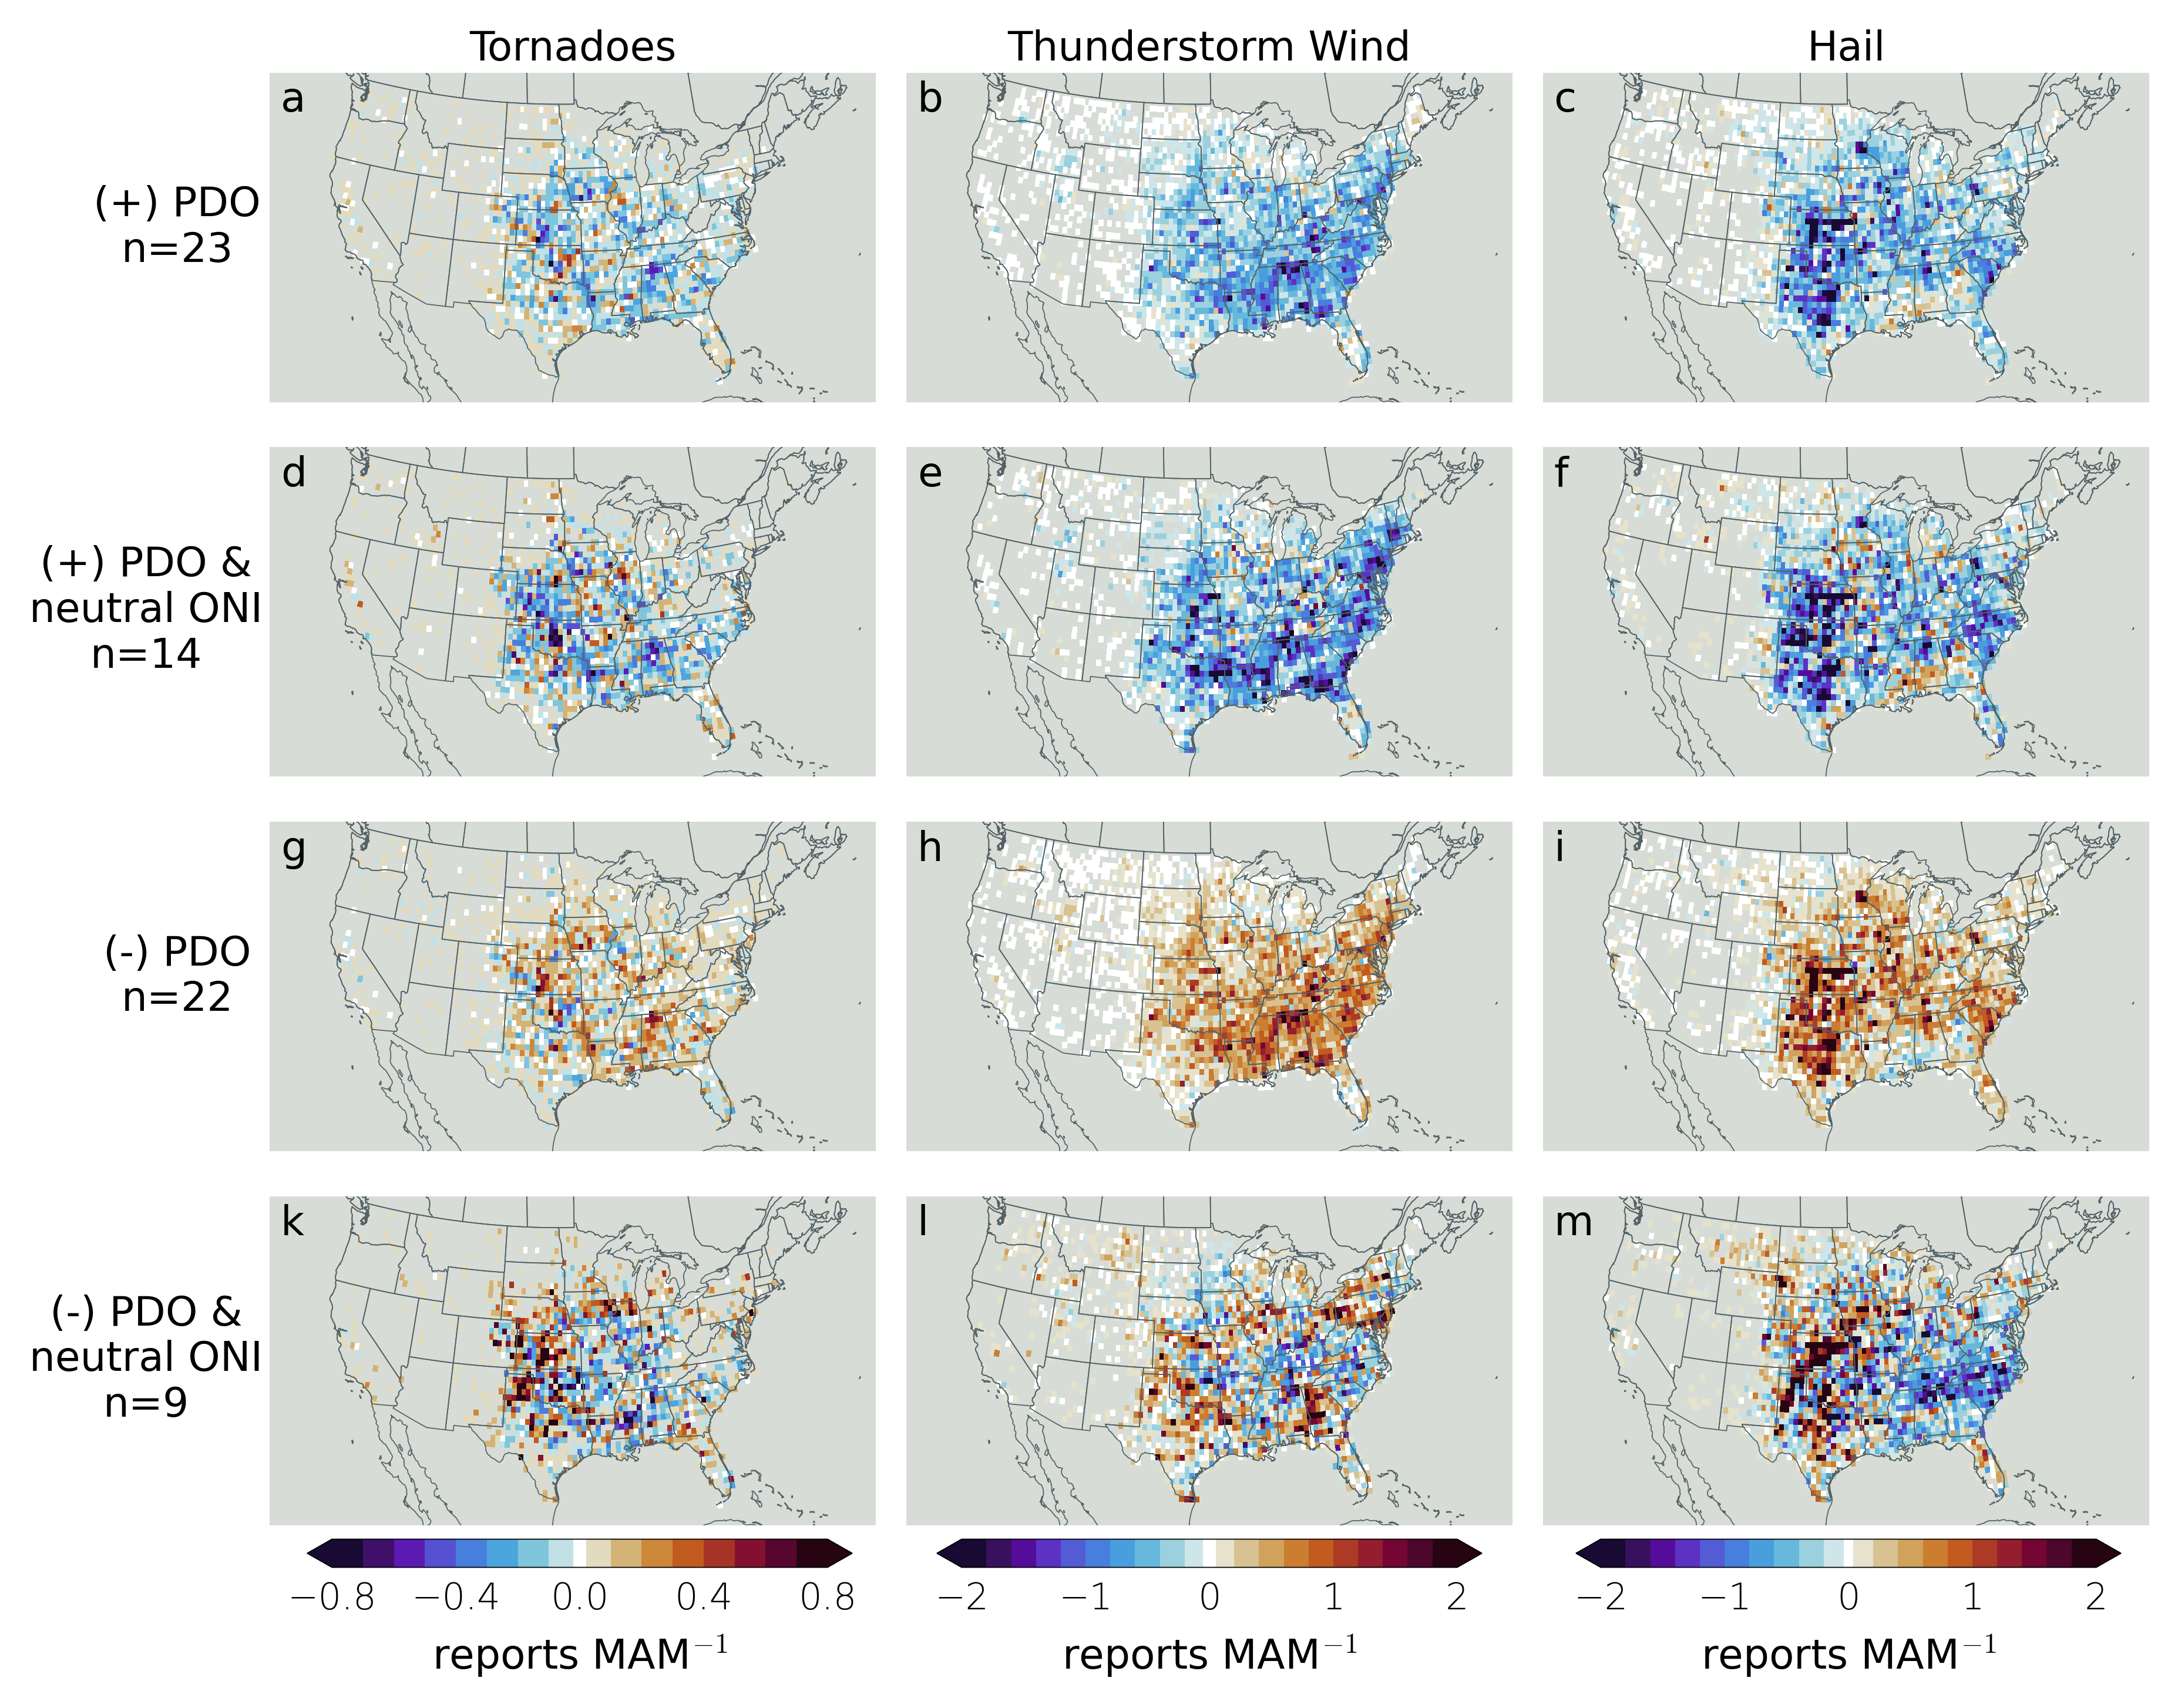

In [125]:
fig, ax = plt.subplots(4, 3, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

ax = [ax[0, 0], ax[0, 1], ax[0, 2], \
      ax[1, 0], ax[1, 1], ax[1, 2], \
      ax[2, 0], ax[2, 1], ax[2, 2], \
      ax[3, 0], ax[3, 1], ax[3, 2]]

tornado_bounds = [-0.8, -0.7, -0.6, -0.5,-0.4, -0.3, -0.2, -0.1, -0.02, 0.02, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
tornado_norm = c.BoundaryNorm(tornado_bounds, plt.get_cmap('cmr.fusion_r').N)

tstorm_wind_bounds = [-2, -1.8, -1.6, -1.4, -1.2, -1, -0.8, -0.6, -.4, -0.2, -0.05, 0.05, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]
tstorm_wind_norm = c.BoundaryNorm(tstorm_wind_bounds, plt.get_cmap('cmr.fusion_r').N)

hail_bounds = [-2, -1.8, -1.6, -1.4, -1.2, -1, -0.8, -0.6, -.4, -0.2, -0.04, 0.04, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]
hail_norm = c.BoundaryNorm(hail_bounds, plt.get_cmap('cmr.fusion_r').N)

lon = lon_edges_0_5deg
lat = lat_edges_0_5deg

letters = ['a', 'b', 'c', \
           'd', 'e', 'f', \
           'g', 'h', 'i', \
           'k', 'l', 'm']

for i in range(12):
    ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')
    ax[i].spines['geo'].set_edgecolor('xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0)
    ax[i].add_feature(ct.feature.STATES, lw=0.25, edgecolor='xkcd:gunmetal')
    ax[i].set_facecolor('xkcd:light gray')
    ax[i].text(-2700000, 1350000, letters[i], fontweight='normal', size=10)

ax[0].pcolormesh(lon, lat, np.flipud(tornado_pos_pdo - tornado_counts_mam_xr.mean(dim='time')), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tornado_norm)
ax[3].pcolormesh(lon, lat, np.flipud(tornado_pos_pdo_neut_oni - tornado_counts_mam_xr.mean(dim='time')), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tornado_norm)
ax[6].pcolormesh(lon, lat, np.flipud(tornado_neg_pdo - tornado_counts_mam_xr.mean(dim='time')), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tornado_norm)
ax[9].pcolormesh(lon, lat, np.flipud(tornado_neg_pdo_neut_oni - tornado_counts_mam_xr.mean(dim='time')), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tornado_norm)

ax[1].pcolormesh(lon, lat, np.flipud(tstorm_wind_pos_pdo - tstorm_wind_counts_mam_xr.mean(dim='time')), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tstorm_wind_norm)
ax[4].pcolormesh(lon, lat, np.flipud(tstorm_wind_pos_pdo_neut_oni - tstorm_wind_counts_mam_xr.mean(dim='time')), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tstorm_wind_norm)
ax[7].pcolormesh(lon, lat, np.flipud(tstorm_wind_neg_pdo - tstorm_wind_counts_mam_xr.mean(dim='time')), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tstorm_wind_norm)
ax[10].pcolormesh(lon, lat, np.flipud(tstorm_wind_neg_pdo_neut_oni - tstorm_wind_counts_mam_xr.mean(dim='time')), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tstorm_wind_norm)

ax[2].pcolormesh(lon, lat, np.flipud(hail_pos_pdo - hail_counts_mam_xr.mean(dim='time')), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=hail_norm)
ax[5].pcolormesh(lon, lat, np.flipud(hail_pos_pdo_neut_oni - hail_counts_mam_xr.mean(dim='time')), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=hail_norm)
ax[8].pcolormesh(lon, lat, np.flipud(hail_neg_pdo - hail_counts_mam_xr.mean(dim='time')), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=hail_norm)
ax[11].pcolormesh(lon, lat, np.flipud(hail_neg_pdo_neut_oni - hail_counts_mam_xr.mean(dim='time')), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=hail_norm)

cax = plt.axes([0.02, .23, 0.29, 0.02])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=tornado_norm), cax=cax, orientation='horizontal', spacing='proportional', extend='both', \
                    ticks=[-0.8, -0.4, 0, 0.4, 0.8])
cbar.set_label(r'reports MAM$^{-1}$', size=10, fontweight='normal', color='black')
cbar.ax.tick_params(which='both', labelsize=9, width=0.5, length=0, labelcolor='black')
cbar.outline.set_linewidth(0.25)
cbar.outline.set_color('black')
# cbar.outline.set_visible(False)

cax2 = plt.axes([0.355, .23, 0.29, 0.02])
cbar2 = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=tstorm_wind_norm), cax=cax2, orientation='horizontal', spacing='proportional', extend='both', \
                     ticks=[-2, -1, 0, 1, 2])
cbar2.set_label(r'reports MAM$^{-1}$', size=10, fontweight='normal', color='black')
cbar2.ax.tick_params(which='both', labelsize=9, width=0.5, length=0, labelcolor='black')
cbar2.outline.set_linewidth(0.25)
cbar2.outline.set_color('black')
# cbar.outline.set_visible(False)

cax3 = plt.axes([0.695, .23, 0.29, 0.02])
cbar3 = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=hail_norm), cax=cax3, orientation='horizontal', spacing='proportional', extend='both', \
                     ticks=[-2, -1, 0, 1, 2])
cbar3.set_label(r'reports MAM$^{-1}$', size=10, fontweight='normal', color='black')
cbar3.ax.tick_params(which='both', labelsize=9, width=0.25, length=0, labelcolor='black')
cbar3.outline.set_linewidth(0.25)
cbar3.outline.set_color('black')
# cbar.outline.set_visible(False)

ax[0].text(-3700000, -100000, f"(+) PDO\nn={len(xr.where(pdo_1980_2024_mam > 0, pdo_1980_2024_mam, np.nan).dropna(dim='time'))}", fontweight='normal', size=10, rotation='horizontal', ha='center')
ax[3].text(-4000000, -400000, f"(+) PDO &\nneutral ONI\nn={len(xr.where((pdo_1980_2024_mam > 0) & (oni_ann_xr == 0), pdo_1980_2024_mam, np.nan).dropna(dim='time'))}", fontweight='normal', size=10, rotation='horizontal', ha='center')
ax[6].text(-3700000, -100000, f"(-) PDO\nn={len(xr.where(pdo_1980_2024_mam < 0, pdo_1980_2024_mam, np.nan).dropna(dim='time'))}", fontweight='normal', size=10, rotation='horizontal', ha='center')
ax[9].text(-4000000, -400000, f"(-) PDO &\nneutral ONI\nn={len(xr.where((pdo_1980_2024_mam < 0) & (oni_ann_xr == 0), pdo_1980_2024_mam, np.nan).dropna(dim='time'))}", fontweight='normal', size=10, rotation='horizontal', ha='center')

ax[0].set_title('Tornadoes', pad=3, fontsize=10)
ax[1].set_title('Thunderstorm Wind', pad=3, fontsize=10)
ax[2].set_title('Hail', pad=3, fontsize=10)

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=1.3, 
                    wspace=0.05, 
                    hspace=0.05)

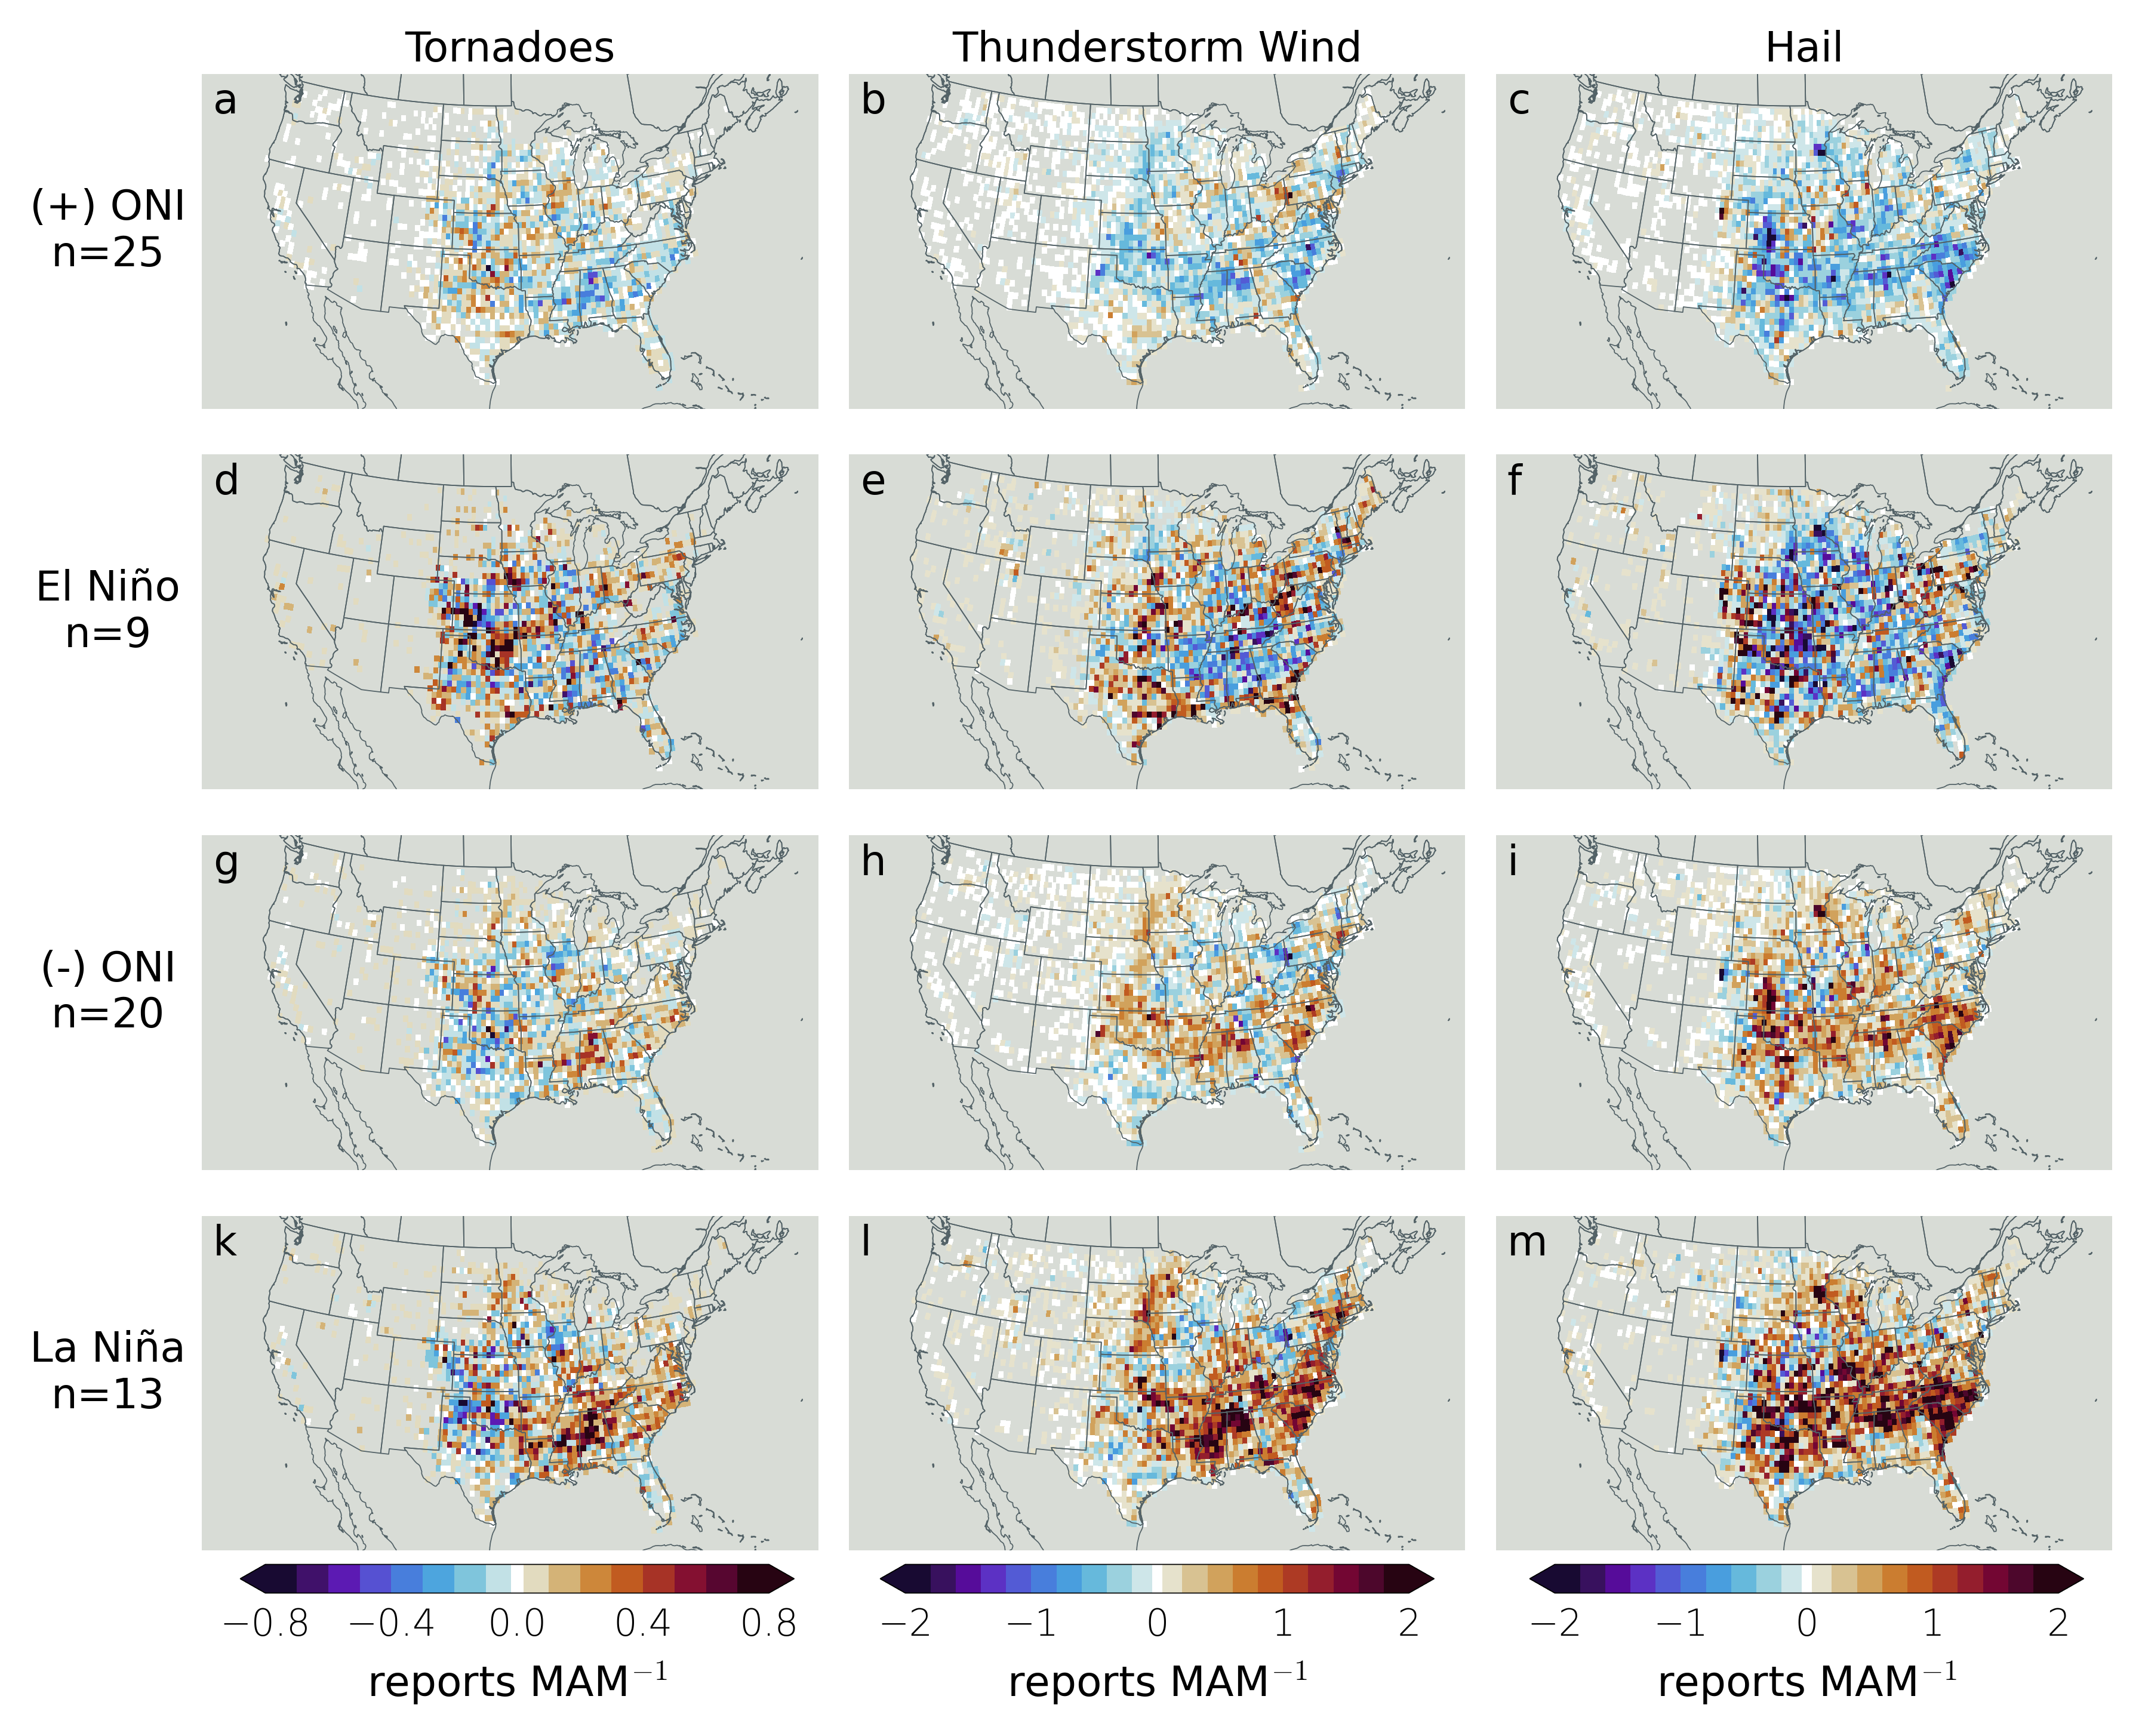

In [115]:
fig, ax = plt.subplots(4, 3, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

ax = [ax[0, 0], ax[0, 1], ax[0, 2], \
      ax[1, 0], ax[1, 1], ax[1, 2], \
      ax[2, 0], ax[2, 1], ax[2, 2], \
      ax[3, 0], ax[3, 1], ax[3, 2]]

letters = ['a', 'b', 'c', \
           'd', 'e', 'f', \
           'g', 'h', 'i', \
           'k', 'l', 'm']

tornado_bounds = [-0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, -0.02, 0.02, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
tornado_norm = c.BoundaryNorm(tornado_bounds, plt.get_cmap('cmr.fusion_r').N)

tstorm_wind_bounds = [-2, -1.8, -1.6, -1.4, -1.2, -1, -0.8, -0.6, -0.4, -0.2, -0.04, 0.04, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]
tstorm_wind_norm = c.BoundaryNorm(tstorm_wind_bounds, plt.get_cmap('cmr.fusion_r').N)

hail_bounds = [-2, -1.8, -1.6, -1.4, -1.2, -1, -0.8, -0.6, -.4, -0.2, -0.04, 0.04, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]
hail_norm = c.BoundaryNorm(hail_bounds, plt.get_cmap('cmr.fusion_r').N)

for i in range(12):
    ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')
    ax[i].spines['geo'].set_edgecolor('xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0)
    ax[i].add_feature(ct.feature.STATES, lw=0.25, edgecolor='xkcd:gunmetal')
    ax[i].set_facecolor('xkcd:light gray')
    ax[i].text(-2700000, 1350000, letters[i], fontweight='normal', size=10)

ax[0].pcolormesh(lon, lat, np.flipud(tornado_pos_oni - tornado_counts_mam_xr.mean(dim='time')), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tornado_norm)
ax[6].pcolormesh(lon, lat, np.flipud(tornado_neg_oni - tornado_counts_mam_xr.mean(dim='time')), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tornado_norm)
ax[3].pcolormesh(lon, lat, np.flipud(tornado_pos_nino - tornado_counts_mam_xr.mean(dim='time')), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tornado_norm)
ax[9].pcolormesh(lon, lat, np.flipud(tornado_neg_nina - tornado_counts_mam_xr.mean(dim='time')), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tornado_norm)

ax[1].pcolormesh(lon, lat, np.flipud(tstorm_wind_pos_oni - tstorm_wind_counts_mam_xr.mean(dim='time')), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tstorm_wind_norm)
ax[7].pcolormesh(lon, lat, np.flipud(tstorm_wind_neg_oni - tstorm_wind_counts_mam_xr.mean(dim='time')), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tstorm_wind_norm)
ax[4].pcolormesh(lon, lat, np.flipud(tstorm_wind_pos_nino - tstorm_wind_counts_mam_xr.mean(dim='time')), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tstorm_wind_norm)
ax[10].pcolormesh(lon, lat, np.flipud(tstorm_wind_neg_nina - tstorm_wind_counts_mam_xr.mean(dim='time')), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tstorm_wind_norm)

ax[2].pcolormesh(lon, lat, np.flipud(hail_pos_oni - hail_counts_mam_xr.mean(dim='time')), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=hail_norm)
ax[8].pcolormesh(lon, lat, np.flipud(hail_neg_oni - hail_counts_mam_xr.mean(dim='time')), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=hail_norm)
ax[5].pcolormesh(lon, lat, np.flipud(hail_pos_nino - hail_counts_mam_xr.mean(dim='time')), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=hail_norm)
ax[11].pcolormesh(lon, lat, np.flipud(hail_neg_nina - hail_counts_mam_xr.mean(dim='time')), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=hail_norm)

cax = plt.axes([0.02, .23, 0.29, 0.02])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=tornado_norm), cax=cax, orientation='horizontal', spacing='proportional', extend='both', \
                    ticks=[-0.8, -0.4, 0, 0.4, 0.8])
cbar.set_label(r'reports MAM$^{-1}$', size=10, fontweight='normal', color='black')
cbar.ax.tick_params(which='both', labelsize=9, width=0.5, length=0, labelcolor='black')
cbar.outline.set_linewidth(0.25)
cbar.outline.set_color('black')
# cbar.outline.set_visible(False)

cax2 = plt.axes([0.355, .23, 0.29, 0.02])
cbar2 = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=tstorm_wind_norm), cax=cax2, orientation='horizontal', spacing='proportional', extend='both', \
                     ticks=[-2, -1, 0, 1, 2])
cbar2.set_label(r'reports MAM$^{-1}$', size=10, fontweight='normal', color='black')
cbar2.ax.tick_params(which='both', labelsize=9, width=0.5, length=0, labelcolor='black')
cbar2.outline.set_linewidth(0.25)
cbar2.outline.set_color('black')
# cbar.outline.set_visible(False)

cax3 = plt.axes([0.695, .23, 0.29, 0.02])
cbar3 = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=hail_norm), cax=cax3, orientation='horizontal', spacing='proportional', extend='both', \
                     ticks=[-2, -1, 0, 1, 2])
cbar3.set_label(r'reports MAM$^{-1}$', size=10, fontweight='normal', color='black')
cbar3.ax.tick_params(which='both', labelsize=9, width=0.25, length=0, labelcolor='black')
cbar3.outline.set_linewidth(0.25)
cbar3.outline.set_color('black')
# cbar.outline.set_visible(False)

ax[0].text(-3700000, -100000, f"(+) ONI\nn={len(xr.where(oni_rolling_1980_2024_mam > 0, oni_rolling_1980_2024_mam, np.nan).dropna(dim='time'))}", fontweight='normal', size=10, rotation='horizontal', ha='center')
ax[6].text(-3700000, -100000, f"(-) ONI\nn={len(xr.where(oni_rolling_1980_2024_mam < 0, oni_rolling_1980_2024_mam, np.nan).dropna(dim='time'))}", fontweight='normal', size=10, rotation='horizontal', ha='center')
ax[3].text(-3700000, -100000, f"El Ni\u00f1o\nn={len(xr.where(oni_ann_xr == 1, oni_ann_xr, np.nan).dropna(dim='time'))}", fontweight='normal', size=10, rotation='horizontal', ha='center')
ax[9].text(-3700000, -100000, f"La Ni\u00f1a\nn={len(xr.where(oni_ann_xr == -1, oni_ann_xr, np.nan).dropna(dim='time'))}", fontweight='normal', size=10, rotation='horizontal', ha='center')

ax[0].set_title('Tornadoes', fontsize=10, pad=3)
ax[1].set_title('Thunderstorm Wind', fontsize=10, pad=3)
ax[2].set_title('Hail', fontsize=10, pad=3)

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=1.3, 
                    wspace=0.05, 
                    hspace=0.05)